In [4]:
from astroplan import Observer, FixedTarget, time_grid_from_range, download_IERS_A, AirmassConstraint,MoonSeparationConstraint, moon_illumination, AltitudeConstraint, AtNightConstraint, is_observable,is_always_observable, months_observable, observability_table,SunSeparationConstraint
from astroplan.plots import plot_sky, plot_airmass, plot_parallactic

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import EarthLocation, get_body, name_resolve, SkyCoord

import matplotlib.pyplot as plt
import warnings

# Update Earth's orientation from Astroplan servers
download_IERS_A()

## Observer setup

Indicate observatory location and specify date & time for observation - see [Anika's Astroplan review notebook](https://igneousearth.github.io/mro/trips/attachments/Astroplan_Anika.ipynb) for reference.

In [10]:
# Set up observer
mro=Observer.at_site('Manastash Ridge Observatory',timezone='US/Pacific')

# Time setup
date_utc = Time.now() # If we're planning to observe tonight
# date_utc = Time("2024-07-01") # If we're planning some day in the future
# date_local = date_utc.to_datetime(timezone=mro.timezone) # We can convert using this

# Observation run details - night of date
observe_start = Time(mro.twilight_evening_astronomical(date_utc, which='nearest'))
observe_end = Time(mro.twilight_morning_astronomical(date_utc, which='nearest'))

window = [observe_start,observe_end]
lst_window = mro.local_sidereal_time(window)

time_resolution=0.5*u.hour
window_time_grid=time_grid_from_range(window,time_resolution=time_resolution)

print('Local:',window[0].to_datetime(timezone=mro.timezone),'-',window[1].to_datetime(timezone=mro.timezone)) 
print('\nLST:',lst_window[0],'-',lst_window[1])
print('UTC:',window[0].iso,'-',window[1].iso)

print('\nTotal observing length is {:.04}'.format((window[1]-window[0]).sec/3600), 'hours of astronomical twilight')

Local: 2024-07-12 23:33:10.491557-07:00 - 2024-07-13 02:44:34.837111-07:00

LST: 17h56m48.64277654s - 21h08m44.43100454s
UTC: 2024-07-13 06:33:10.492 - 2024-07-13 09:44:34.837

Total observing length is 3.19 hours of astronomical twilight


## Airmass plots for targets

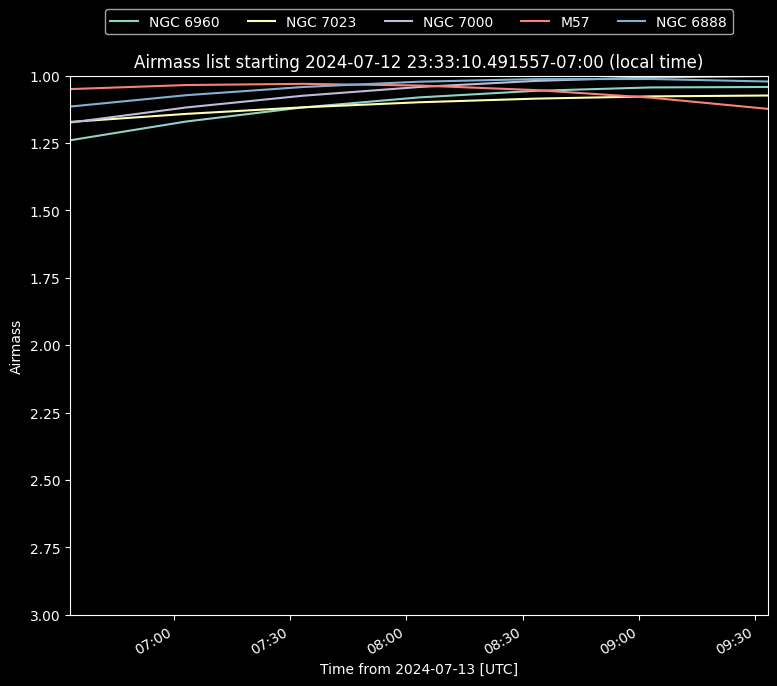

In [16]:
TARGET_NAMES = ['NGC 6960', 'NGC 7023', 'NGC 7000', 'M57', 'NGC 6888', 'M27']

TARGET_LIST = []

for target in TARGET_NAMES:
    try:
        tgt = FixedTarget.from_name(target)
        TARGET_LIST.append(tgt)
    except name_resolve.NameResolveError:
        # target not found - try checking solar system bodies
        try:
            coord = get_body(target, observe_start, location=EarthLocation.of_site("Manastash Ridge Observatory"))
            tgt = FixedTarget(coord=coord, name=target)
            TARGET_LIST.append(tgt)
        except name_resolve.NameResolveError:
            # target still not found - check astropy's more comprehensive name_resolve
            try:
                coord = name_resolve.get_icrs_coordinates(target)
                tgt = FixedTarget(coord=coord, name=target)
                TARGET_LIST.append(tgt)
            except:
                print("Target {} not found.".format(target))

# If a target can't be found, manually add it below.
# coord = SkyCoord("20h14m56.2s -23d06m49.5s", obstime=observe_start, unit='deg')
# tgt = FixedTarget(coord=coord, name="Pluto")
# TARGET_LIST.append(tgt)

plt.figure(figsize=(9,7))
plt.title("Airmass list starting {} (local time)".format(window[0].to_datetime(timezone=mro.timezone)))
for target in TARGET_LIST:
    plot_airmass(target, mro, window_time_grid, max_airmass=3)
# plot_airmass(moon,apo,window_time_grid)
plt.legend(loc='center', bbox_to_anchor=(.5,1.1),ncol=8);